### Imports and global variables

In [1]:
import pandas as pd
import seaborn as sns
import pickle

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, LabelBinarizer
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
from lightgbm import LGBMClassifier

from tland_utility import RidgeClassifierWithProb, DummyClassifierReturnOriginal, RidgeClassifierMultiClassWithProb, ColumnSelectorWPred

from itertools import combinations, cycle

import time

%matplotlib inline

/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cells = ['GM12878','A549','H1hESC','HepG2','K562','MCF7']
# cells_aa = ['A549_aa', 'H1hESC_aa']
# cells_ada = ['A549_ada', 'H1hESC_ada']
# cells_aa = ['embryo_aa', 'lung_aa']
# cells_ada = ['H9_ada', 'IMR90_ada']
cells_addition = ['A549(IMR90)', 'IMR90(GM12878)', 'IMR90(A549)', 'IMR90(H1hESC)', 'IMR90(HepG2)', 'IMR90(K562)', 'IMR90(MCF7)', 'IMR90(IMR90)',
                 'H1hESC(H9)', 'H9(GM12878)', 'H9(A549)', 'H9(H1hESC)', 'H9(HepG2)', 'H9(K562)', 'H9(MCF7)', 'H9(H9)']

features_generic_wo_funsig = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched','FOOTPRINT_matched','IC_max','IC_matched_max',
                              'ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3', 
                              'DNase_var','DNase_quantile95','DNase_quantile1','DNase_quantile2','DNase_quantile3']

features_sei = ['PC1 Polycomb / Heterochromatin','L1 Low signal','TN1 Transcription','TN2 Transcription','L2 Low signal',
                'E1 Stem cell','E2 Multi-tissue','E3 Brain / Melanocyte','L3 Low signal','E4 Multi-tissue','TF1 NANOG / FOXA1',
                'HET1 Heterochromatin','E5 B-cell-like','E6 Weak epithelial','TF2 CEBPB','PC2 Weak Polycomb','E7 Monocyte / Macrophage',
                'E8 Weak multi-tissue','L4 Low signal','TF3 FOXA1 / AR / ESR1','PC3 Polycomb','TN3 Transcription',
                'L5 Low signal','HET2 Heterochromatin','L6 Low signal','P Promoter','E9 Liver / Intestine','CTCF CTCF-Cohesin','TN4 Transcription',
                'HET3 Heterochromatin','E10 Brain','TF4 OTX2','HET4 Heterochromatin','L7 Low signal',
                'PC4 Polycomb / Bivalent stem cell Enh','HET5 Centromere','E11 T-cell','TF5 AR','E12 Erythroblast-like','HET6 Centromere']

#removed H3K9me3
features_names_cell_sp = ['H2AFZ_cellSp',
 'H3K27ac_cellSp',
 'H3K27me3_cellSp',
 'H3K36me3_cellSp',
 'H3K4me1_cellSp',
 'H3K4me2_cellSp',
 'H3K4me3_cellSp',
 'H3K79me2_cellSp',
 'H3K9ac_cellSp',
 'H4K20me1_cellSp',
 'DNASE_cellSp',
 'FOOTPRINT_cellSp']

#Use less histone marks
features_names_cell_sp_2 = ['H3K27ac_cellSp',
 'H3K36me3_cellSp',
 'H3K4me1_cellSp',
 'H3K4me3_cellSp',
 'H3K27me3_cellSp',
 'DNASE_cellSp',
 'FOOTPRINT_cellSp']


features_names_organ_sp = ['DNASE_organSp', 'DNASE_organSp_perc', 
                           'CHIP_organSp', 'CHIP_organSp_perc', 'CHIP_organSp_uniq',
                           'FOOTPRINT_organSp', 
                           'H3K27ac_organSp','H3K27ac_organSp_perc',
                           'H3K36me3_organSp','H3K36me3_organSp_perc',
                           'H3K4me1_organSp','H3K4me1_organSp_perc',
                           'H3K4me3_organSp','H3K4me3_organSp_perc',
                           'H3K27me3_organSp', 'H3K27me3_organSp_perc']
features_names_organ_sp_perc = ['DNASE_organSp_perc','CHIP_organSp_perc',
                                'H3K27ac_organSp_perc','H3K36me3_organSp_perc',
                                'H3K4me1_organSp_perc','H3K4me3_organSp_perc',
                                'H3K27me3_organSp_perc', 'CHIP_organSp_uniq', 'FOOTPRINT_organSp']
features_names_organ_sp_dnase=['DNase_var_organSp','DNase_quantile95_organSp','DNase_quantile1_organSp',
                               'DNase_quantile2_organSp','DNase_quantile3_organSp']

features_names_organ_sp_perc_histone = ['DNASE_organSp_perc','H3K27ac_organSp_perc',
                                        'H3K36me3_organSp_perc', 'H3K4me1_organSp_perc',
                                        'H3K4me3_organSp_perc', 'H3K27me3_organSp_perc',
                                        'FOOTPRINT_organSp']



features_generic_light = ['EQTL_2','ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3','DNase_var','DNase_quantile2']

features_names_organ_sp_perc_light = ['DNASE_organSp_perc','CHIP_organSp_perc',
                                      'H3K27ac_organSp_perc','H3K36me3_organSp_perc',
                                      'H3K4me1_organSp_perc','H3K4me3_organSp_perc',
                                      'H3K27me3_organSp_perc', 
                                      'FOOTPRINT_organSp', 
                                      'DNase_var_organSp', 'DNase_quantile2_organSp']

features_data_avail = ['CHIP_organSp_TOTAL', 'CHIP_organSp_uniq','CHIP_organSp_biosample_uniq', 
                       'DNASE_organSp_TOTAL', 'DNASE_organSp_biosample_uniq', 
                       'H3K27ac_organSp_TOTAL', 'H3K36me3_organSp_TOTAL', 'H3K4me1_organSp_TOTAL', 'H3K4me3_organSp_TOTAL', 'H3K27me3_organSp_TOTAL']

In [3]:
features_generic_wo_funsig_hg19 = ['CHIP_hg19','DNASE_hg19','PWM_hg19','FOOTPRINT_hg19','EQTL_2_hg19','PWM_matched_hg19','FOOTPRINT_matched_hg19',
                                   'IC_change_hg19','IC_matched_change_hg19',
                                   'ChIP_var_hg19','ChIP_max_hg19','ChIP_quantile1_hg19','ChIP_quantile2_hg19','ChIP_quantile3_hg19']
features_sei_hg19 = [feature+'_hg19' for feature in features_sei]
features_names_cell_sp_2_hg19 = [feature+'_hg19' for feature in features_names_cell_sp_2]

### 1. Read in data

In [4]:
with open('../data/ASB/df_all_dict_hg38_final.pickle', 'rb') as file:
    df_all_dict = pickle.load(file)
df_all_dict[cells[0]]

,chrom,end,ref,alt,label,cellSp_label,GenoNet,GenoSkyline,funsig,cell,...,H3K4me1_organSp_perc,H3K4me3_organSp_perc,H3K27me3_organSp_perc,DNase_var_organSp,DNase_quantile95_organSp,DNase_quantile1_organSp,DNase_quantile2_organSp,DNase_quantile3_organSp,CTCF_organSp,CTCF_organSp_perc
0,chr10,10065304,A,G,1,0,0.0235,0.001172,0.022459,Others,...,0.000000,0.000000,0.023256,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000
1,chr10,99605545,G,A,1,0,0.0306,0.001172,0.158940,Others,...,0.027027,0.000000,0.000000,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000
2,chr10,100085028,A,G,1,0,0.0384,0.001172,0.004548,Others,...,0.000000,0.000000,0.069767,0.0000,0.0040,0.0001,0.0008,0.0018,4,0.108108
3,chr10,100267650,C,T,1,1,1.0000,0.999998,0.001705,GM12878,...,0.027027,0.912281,0.000000,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000
4,chr10,100325140,C,T,1,0,0.0227,0.001172,0.191050,Others,...,0.000000,0.000000,0.023256,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14768,chr9,111004475,C,T,0,0,0.0088,0.001172,0.137450,Others,...,0.000000,0.000000,0.000000,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000
14769,chr1,197111572,C,T,0,0,0.0156,0.001172,0.205070,Others,...,0.000000,0.000000,0.000000,0.0008,0.0751,0.0017,0.0042,0.0222,0,0.000000
14770,chr4,72624487,C,G,0,0,0.0195,0.001172,0.097861,Others,...,0.000000,0.000000,0.000000,0.0004,0.0589,0.0012,0.0030,0.0122,0,0.000000
14771,chr11,19064335,G,C,0,0,0.0213,0.001172,0.406100,Others,...,0.000000,0.000000,0.023256,0.0000,0.0040,0.0001,0.0008,0.0018,0,0.000000


In [5]:
#organ label adjustment
blood_cell_lines = ['GM12878', 'K562']
for cell in cells+cells_addition:
    if cell in blood_cell_lines:
        df_all_dict[cell]['organSp_label'] =  (df_all_dict[cell][blood_cell_lines].sum(axis=1) > 0).astype(int)
    else:
        df_all_dict[cell]['organSp_label'] = df_all_dict[cell]['cellSp_label']

### 2.1 Define T-Land model

In [6]:
def get_TLand(features_generic, features_cell_sp, features_sei, class_balance, kfold=4, random_state=934, njobs=40):
    rf_dict = {'n_estimators':300, 'oob_score':True, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    lgbm_dict={'num_boost_round':250, 'learning_rate':0.049, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    nn_dict={'hidden_layer_sizes':(128, 128, 128), 'batch_size':128, 'learning_rate':'adaptive','random_state':random_state, 'verbose':True, 'max_iter':30}
    log_dict = {'max_iter':10000, 'random_state':random_state, 'class_weight':class_balance, 'penalty':'l2', 'C':1, 'solver':'lbfgs'}
    xt_dict = {'n_estimators':300, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    
    exp_features = features_generic + features_cell_sp
    exp_component = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', RandomForestClassifier(**rf_dict))])
    exp_component_lgbm = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', LGBMClassifier(**lgbm_dict))])
#     exp_component_knn = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', KNeighborsClassifier(weights='distance'))])
#     exp_component_xt = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', ExtraTreesClassifier(**xt_dict))])
    exp_component_nn = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', MLPClassifier(**nn_dict))])
#     exp_component_log = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', LogisticRegression(**log_dict))])
    
    dl_features = features_sei + features_cell_sp
    dl_seq_based_component = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', RandomForestClassifier(**rf_dict))])
    dl_seq_based_component_lgbm = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', LGBMClassifier(**lgbm_dict))])
#     dl_seq_based_component_knn = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', KNeighborsClassifier(weights='distance'))])
#     dl_seq_based_component_xt = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', ExtraTreesClassifier(**xt_dict))])
    dl_seq_based_component_nn = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', MLPClassifier(**nn_dict))])
#     dl_seq_based_component_log = Pipeline([('dl_features_col_sel', ColumnSelector(cols=dl_features)), ('rf', LogisticRegression(**log_dict))])
    
    cell_sp_component = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', RandomForestClassifier(**rf_dict))])
    cell_sp_component_lgbm = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', LGBMClassifier(**lgbm_dict))])
#     cell_sp_component_knn = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', KNeighborsClassifier(weights='distance'))])
#     cell_sp_component_xt = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', ExtraTreesClassifier(**xt_dict))])
    cell_sp_component_nn = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', MLPClassifier(**nn_dict))])
#     cell_sp_component_log = Pipeline([('cell_sp_features_col_sel', ColumnSelector(cols=features_cell_sp)), ('rf', LogisticRegression(**log_dict))])
#     sei_component = Pipeline([('sei_features_col_sel', ColumnSelector(cols=features_sei)), ('rf', RandomForestClassifier(n_estimators=1000, max_depth=500, 
#                                                                                                                      criterion='gini',random_state=100,oob_score=True, n_jobs=40, class_weight="balanced"))])
    
#     all_features = features_generic+features_cell_sp+features_sei
#     all_rf = Pipeline([('all_col_sel', ColumnSelector(cols=all_features)), ('rf', RandomForestClassifier(**rf_dict))])
#     all_lgbm = Pipeline([('all_col_sel', ColumnSelector(cols=all_features)), ('rf', LGBMClassifier(**lgbm_dict))])
#     all_nn = Pipeline([('all_col_sel', ColumnSelector(cols=all_features)), ('rf', MLPClassifier(**nn_dict))])
    
#     int_feature_name = [f'{cell_sp_feature}_X_max_abs_diff' for cell_sp_feature in features_cell_sp]
    
#     passby_features_ls = []
#     for passby_feature in ['DNASE_cellSp','max_abs_diff', 'funsig']:
#         passby_features_ls.append((passby_feature, Pipeline([('cell_id', ColumnSelector(cols=[passby_feature])),  ('dummy', DummyClassifierReturnOriginal())])))
    
    estimators = [('exp_component', exp_component), 
                  ('exp_component_lgbm', exp_component_lgbm),
#                   ('exp_component_knn', exp_component_knn), 
#                   ('exp_component_xt', exp_component_xt), 
#                   ('exp_component_log', exp_component_log), 
                  ('exp_component_nn', exp_component_nn), 
                  ('dl_seq_based_component', dl_seq_based_component), 
                  ('dl_seq_based_component_lgbm', dl_seq_based_component_lgbm), 
#                   ('dl_seq_based_component_knn', dl_seq_based_component_knn), 
#                   ('dl_seq_based_component_xt', dl_seq_based_component_xt), 
#                   ('dl_seq_based_component_log', dl_seq_based_component_log), 
                  ('dl_seq_based_component_nn', dl_seq_based_component_nn), 
                  ('cell_sp_component', cell_sp_component), 
                  ('cell_sp_component_lgbm', cell_sp_component_lgbm), 
#                   ('cell_sp_component_knn', cell_sp_component_knn), ]
#                   ('cell_sp_component_xt', cell_sp_component_xt),] 
#                   ('cell_sp_component_log', cell_sp_component_log),]
                  ('cell_sp_component_nn', cell_sp_component_nn),]
#                   ('all_rf', all_rf), 
#                   ('all_lgbm', all_lgbm), 
#                   ('all_nn', all_nn)]
#     + passby_features_ls
#                   ('sei_component', sei_component),
#                   ('all_rf', all_rf)]

#     final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ('ridgeclassifier', GradientBoostingClassifier(random_state=random_state))]) #, positive=True
#     final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ('ridgeclassifier', RidgeClassifierMultiClassWithProb(random_state=100, class_weight="balanced", alpha=1.9))]) #, positive=True
    final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ('ridgeclassifier', RidgeClassifierWithProb(random_state=100, class_weight="balanced", alpha=1.9))]) #, positive=True
#     final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), 
#                                 ('logit', LogisticRegression(random_state=random_state,class_weight="balanced", penalty='elasticnet', solver='saga', max_iter=10000, l1_ratio=0.5))]) #, positive=True
#     final_estimator = Pipeline([('feats', FeatureUnion([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), 
#                                                         ('select_int_features', ColumnSelector(cols=int_feature_name))])), 
#                                 ('logit', LogisticRegression(random_state=random_state,class_weight="balanced", penalty='elasticnet', solver='saga', max_iter=10000, l1_ratio=0.5))])
#     final_estimator = RidgeClassifierWithProb(random_state=100, class_weight="balanced", alpha=1.9) #, positive=True
#     final_estimator = LogisticRegression(random_state=100,class_weight="balanced")
#     final_estimator = DecisionTreeClassifier(random_state=100, class_weight="balanced")
#     final_estimator = RandomForestClassifier(random_state=100, class_weight="balanced")
    

#     final_estimator = LogisticRegression(class_weight="balanced", solver='lbfgs')

#     final_estimator = LogisticRegressionS(solver="ecos", penalty="l1")
#     final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ('logit', LogisticRegressionBinaryClassifier(enforce_non_negativity=True, quiet=True,normalize='No', l1_regularization=0))])
    
    group_kfold = StratifiedGroupKFold(n_splits=kfold)
    
    clf = StackingCVClassifier(classifiers=[estimator[1] for estimator in estimators], meta_classifier=final_estimator, 
                               use_probas=True, drop_proba_col='first', cv=group_kfold, random_state=100, n_jobs=njobs, 
                               store_train_meta_features=True)
    
    name_ls = [estimator[0] for estimator in estimators]
    
    return clf, name_ls

In [7]:
def get_TLand_light(features, class_balance, kfold=4, random_state=934, njobs=40):
    rf_dict = {'n_estimators':300, 'oob_score':True, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    lgbm_dict={'num_boost_round':250, 'learning_rate':0.049, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    nn_dict={'hidden_layer_sizes':(128, 128, 128), 'batch_size':128, 'learning_rate':'adaptive','random_state':random_state, 'verbose':True, 'max_iter':30}
    log_dict = {'max_iter':10000, 'random_state':random_state, 'class_weight':class_balance, 'penalty':'l2', 'C':1, 'solver':'lbfgs'}
    xt_dict = {'n_estimators':300, 'random_state':random_state, 'n_jobs':njobs, 'class_weight':class_balance}
    
    exp_features = features
    exp_component = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', RandomForestClassifier(**rf_dict))])
    exp_component_lgbm = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', LGBMClassifier(**lgbm_dict))])
    exp_component_nn = Pipeline([('exp_features_col_sel', ColumnSelector(cols=exp_features)), ('rf', MLPClassifier(**nn_dict))])
    
    estimators = [('exp_component', exp_component), 
                  ('exp_component_lgbm', exp_component_lgbm),
                  ('exp_component_nn', exp_component_nn)]

    final_estimator = Pipeline([('poly_trans', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ('ridgeclassifier', RidgeClassifierWithProb(random_state=100, class_weight="balanced", alpha=1.9))]) #, positive=True

    group_kfold = StratifiedGroupKFold(n_splits=kfold)
    
    clf = StackingCVClassifier(classifiers=[estimator[1] for estimator in estimators], meta_classifier=final_estimator, 
                               use_probas=True, drop_proba_col='first', cv=group_kfold, random_state=100, n_jobs=njobs, 
                               store_train_meta_features=True)
    
    name_ls = [estimator[0] for estimator in estimators]
    
    return clf, name_ls

### 2.2 Define other models

In [11]:
def train_TURF_hg19(cell):
    # with open('./turf_training/ASB_SNVs/generic/ASB_rf_IC_change_add_control.pkl', 'rb') as f:
    #     clf_generic = pickle.load(f)
    #generic features
    features = ['CHIP_hg19','DNASE_hg19','PWM_hg19','FOOTPRINT_hg19','EQTL_2_hg19','PWM_matched_hg19',
                'FOOTPRINT_matched_hg19','IC_change_hg19','IC_matched_change_hg19',
                'funsig','ChIP_var_hg19','ChIP_max_hg19','ChIP_quantile1_hg19','ChIP_quantile2_hg19','ChIP_quantile3_hg19']
    features_cell_sp = ['H3K27ac_cellSp_hg19','H3K36me3_cellSp_hg19','H3K4me1_cellSp_hg19',
                        'H3K4me3_cellSp_hg19','H3K27me3_cellSp_hg19','DNASE_cellSp_hg19','FOOTPRINT_cellSp_hg19']
    # y_scores = clf_generic.predict_proba(df_all_dict['A549'][features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if other_cell!=cell]
    df_all_dict[cell]['Others_leaveOne'] = (df_all_dict['A549'][other_cells].sum(axis=1) == 1).astype(int)

    # Train cell id clf and predict proba
    clf_generic = RandomForestClassifier(n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict[cell][features], 
                                                                                               df_all_dict[cell]['Others_leaveOne'])
    clf_turf = dict()
    for other_cell in other_cells:
        clf_turf[other_cell]=RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict[other_cell][features_cell_sp], 
                                                                                                                                  df_all_dict[other_cell]['cellSp_label'])
    
    return clf_generic, clf_turf

def TURF_hg19_predict_proba(clf_generic, clf_turf, cell, X_test):
    features_cell_sp = ['H3K27ac_cellSp_hg19','H3K36me3_cellSp_hg19','H3K4me1_cellSp_hg19',
                                'H3K4me3_cellSp_hg19','H3K27me3_cellSp_hg19','DNASE_cellSp_hg19','FOOTPRINT_cellSp_hg19']
    features = ['CHIP_hg19','DNASE_hg19','PWM_hg19','FOOTPRINT_hg19','EQTL_2_hg19','PWM_matched_hg19',
                'FOOTPRINT_matched_hg19','IC_change_hg19','IC_matched_change_hg19',
                'funsig','ChIP_var_hg19','ChIP_max_hg19','ChIP_quantile1_hg19','ChIP_quantile2_hg19','ChIP_quantile3_hg19']
    
    y_scores = clf_generic.predict_proba(X_test[features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if other_cell!=cell]
    
    y_pred_ls = []
    for other_cell in other_cells:
        y_pred = clf_turf[other_cell].predict_proba(X_test[features_cell_sp])[:, 1]
        y_pred = y_pred * y_scores
        y_pred_ls.append(y_pred)
    y_pred = np.average(y_pred_ls, axis=0)
    return y_pred

In [5]:
def train_TURF_hg38(cell):
    # with open('./turf_training/ASB_SNVs/generic/ASB_rf_IC_change_add_control.pkl', 'rb') as f:
    #     clf_generic = pickle.load(f)
    #generic features
    features = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched',
                'FOOTPRINT_matched','IC_max','IC_matched_max',
                'funsig','ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3']
    features_cell_sp = ['H3K27ac_cellSp','H3K36me3_cellSp','H3K4me1_cellSp',
                        'H3K4me3_cellSp','H3K27me3_cellSp','DNASE_cellSp','FOOTPRINT_cellSp']
    # y_scores = clf_generic.predict_proba(df_all_dict['A549'][features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if other_cell!=cell]
    df_all_dict[cell]['Others_leaveOne'] = (df_all_dict['A549'][other_cells].sum(axis=1) == 1).astype(int)

    # Train cell id clf and predict proba
    clf_generic = RandomForestClassifier(n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict[cell][features], 
                                                                                               df_all_dict[cell]['Others_leaveOne'])
    clf_turf = dict()
    for other_cell in other_cells:
        clf_turf[other_cell]=RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict[other_cell][features_cell_sp], 
                                                                                                                                  df_all_dict[other_cell]['cellSp_label'])
    
    return clf_generic, clf_turf

def TURF_hg38_predict_proba(clf_generic, clf_turf, cell, X_test):
    features = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched',
                'FOOTPRINT_matched','IC_max','IC_matched_max',
                'funsig','ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3']
    features_cell_sp = ['H3K27ac_cellSp','H3K36me3_cellSp','H3K4me1_cellSp',
                        'H3K4me3_cellSp','H3K27me3_cellSp','DNASE_cellSp','FOOTPRINT_cellSp']
    
    y_scores = clf_generic.predict_proba(X_test[features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if other_cell!=cell]
    
    y_pred_ls = []
    for other_cell in other_cells:
        y_pred = clf_turf[other_cell].predict_proba(X_test[features_cell_sp])[:, 1]
        y_pred = y_pred * y_scores
        y_pred_ls.append(y_pred)
    y_pred = np.average(y_pred_ls, axis=0)
    return y_pred

In [8]:
def train_TURF_hg38_cell_ls(cell_ls):
    # with open('./turf_training/ASB_SNVs/generic/ASB_rf_IC_change_add_control.pkl', 'rb') as f:
    #     clf_generic = pickle.load(f)
    #generic features
    features = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched',
                'FOOTPRINT_matched','IC_max','IC_matched_max',
                'funsig','ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3']
    features_cell_sp = ['H3K27ac_cellSp','H3K36me3_cellSp','H3K4me1_cellSp',
                        'H3K4me3_cellSp','H3K27me3_cellSp','DNASE_cellSp','FOOTPRINT_cellSp']
    # y_scores = clf_generic.predict_proba(df_all_dict['A549'][features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell_ls]
    df_all_dict['A549']['Others_leaveOne'] = (df_all_dict['A549'][other_cells].sum(axis=1) == 1).astype(int)

    # Train cell id clf and predict proba
    clf_generic = RandomForestClassifier(n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict['A549'][features], 
                                                                                               df_all_dict['A549']['Others_leaveOne'])
    clf_turf = dict()
    for other_cell in other_cells:
        clf_turf[other_cell]=RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=100,oob_score=True).fit(df_all_dict[other_cell][features_cell_sp], 
                                                                                                                                  df_all_dict[other_cell]['cellSp_label'])
    
    return clf_generic, clf_turf

def TURF_hg38_predict_proba_cell_ls(clf_generic, clf_turf, cell_ls, X_test):
    features = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched',
                'FOOTPRINT_matched','IC_max','IC_matched_max',
                'funsig','ChIP_var','ChIP_quantile95','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3']
    features_cell_sp = ['H3K27ac_cellSp','H3K36me3_cellSp','H3K4me1_cellSp',
                        'H3K4me3_cellSp','H3K27me3_cellSp','DNASE_cellSp','FOOTPRINT_cellSp']
    
    y_scores = clf_generic.predict_proba(X_test[features])[:,1]
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell_ls]
    
    y_pred_ls = []
    for other_cell in other_cells:
        y_pred = clf_turf[other_cell].predict_proba(X_test[features_cell_sp])[:, 1]
        y_pred = y_pred * y_scores
        y_pred_ls.append(y_pred)
    y_pred = np.average(y_pred_ls, axis=0)
    return y_pred

### 3. Train test split for hold on cell line

In [9]:
def get_data_one_control(cell='GM12878', class_weight_factor=1, fold=5, seq_len=51):
    
    control_pos_df = df_all_dict['A549'].loc[df_all_dict['A549'][cells].sum(axis=1) == 0, :]
    exc_control_idx = (~df_all_dict['A549'].index.isin(control_pos_df.index))
    
    other_cells = [other_cell for other_cell in cells if other_cell!=cell]
    print(other_cells)
    
    df_all_dict_cp = df_all_dict.copy()
    for ind, other_cell in enumerate(other_cells):
        df_all_dict_cp[other_cell]['cell_group'] = ind
    
    # separate negatives for cell and other_cells
    other_cells_control_idx, cell_control_idx = train_test_split([i for i in range(len(exc_control_idx)) if not exc_control_idx[i]], random_state=934, test_size=1/6)

    other_cells_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in other_cells_control_idx:
        other_cells_control_idx_bool[idx] = True
    cell_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in cell_control_idx:
        cell_control_idx_bool[idx] = True
    
    # train data
    df_all_concat_one_control = pd.concat([df_all_dict_cp[other_cell].loc[exc_control_idx, :] for other_cell in other_cells]) #exclude controls
    if cell is not None:
        df_all_concat_one_control = df_all_concat_one_control.loc[df_all_concat_one_control[cell] != 1, :] #exclude negatives of cell positive group
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934)

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[other_cells_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=2, random_state=934)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)
    
    X_train = df_all_concat_one_control
    y_train = df_all_concat_one_control['cellSp_label']
    
    # y_base
    X_train['cellSp_label_max'] = np.NaN
    for index, row in X_train.groupby(['group'])['cellSp_label'].max().iteritems():
        X_train.loc[X_train['group'] == index, 'cellSp_label_max'] = row
    X_train['cellSp_label_max'] = X_train['cellSp_label_max'].astype(int)
    
    # split ahead of time for autogluon
    group_kfold = StratifiedGroupKFold(n_splits=fold)
    for (train_idxs, test_idxs), i in zip(group_kfold.split(X_train, y_train, groups=X_train['group']), range(fold)):
        X_train.loc[test_idxs, 'group_split'] = i
    X_train['group_split'] = X_train['group_split'].astype(int)
    
#     for cell_sp_feature in features_names_cell_sp_2:
#         X_train[f'{cell_sp_feature}_X_max_abs_diff']=(X_train[f'{cell_sp_feature}']+0.1)*X_train['max_abs_diff']
    
#     X_train['start_seq'] = X_train['end'] - 26
#     X_train['end_seq'] = X_train['start_seq'] + seq_len
#     seq_BedTool = pybedtools.BedTool.from_dataframe(X_train[['chrom', 'start_seq', 'end_seq']]).sequence(fi='/data/genomes/hg38/seq/hg38.fa', tab=True)
#     with open(seq_BedTool.seqfn) as fasta:
#             seq_ls = [line.strip().split('\t')[1].lower() for line in fasta]
#     X_train['seq'] = seq_ls


    
    
    #test data
    if cell is None:
        return X_train, y_train, _, _
    df_all_concat_one_control = pd.concat([df_all_dict_cp[cell_type].loc[(df_all_dict_cp[cell_type][cell]==1) & 
                                                  (~df_all_dict_cp[cell_type]['cell'].isin(other_cells)), :] for cell_type in cells])
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934) #include all test cell pos and sample one negative from other cells

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[cell_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934)
    df_all_concat_all_controls = pd.concat([df_all_concat_all_controls, df_all_dict_cp[cell].loc[cell_control_idx_bool, :]]).reset_index(drop=True)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)

    X_test = df_all_concat_one_control
    y_test = df_all_concat_one_control['cellSp_label']
    
    # y_base
    X_test['cellSp_label_max'] = np.NaN
    for index, row in X_test.groupby(['group'])['cellSp_label'].max().iteritems():
        X_test.loc[X_test['group'] == index, 'cellSp_label_max'] = row
    X_test['cellSp_label_max'] = X_test['cellSp_label_max'].astype(int)
    
#     for cell_sp_feature in features_names_cell_sp_2:
#         X_test[f'{cell_sp_feature}_X_max_abs_diff']=(X_test[f'{cell_sp_feature}']+0.1)*X_test['max_abs_diff']
    
#     X_test['start_seq'] = X_test['end'] - 26
#     X_test['end_seq'] = X_test['start_seq'] + seq_len
#     seq_BedTool = pybedtools.BedTool.from_dataframe(X_test[['chrom', 'start_seq', 'end_seq']]).sequence(fi='/data/genomes/hg38/seq/hg38.fa', tab=True)
#     with open(seq_BedTool.seqfn) as fasta:
#             seq_ls = [line.strip().split('\t')[1].lower() for line in fasta]
#     X_test['seq'] = seq_ls
    
    return  X_train, y_train, X_test, y_test

In [10]:
def get_data_one_control_cell_ls(cell=['GM12878', 'K562'], class_weight_factor=1, fold=5, seq_len=51):
    """Assumption is that cells in the list will have a union of label, e.g. if classify with GM12878 features, positive label would be GM12878 or K562.
    
    """
    
    control_pos_df = df_all_dict['A549'].loc[df_all_dict['A549'][cells].sum(axis=1) == 0, :]
    exc_control_idx = (~df_all_dict['A549'].index.isin(control_pos_df.index))
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell]
    print(other_cells)
    
    df_all_dict_cp = df_all_dict.copy()
    for ind, other_cell in enumerate(other_cells):
        df_all_dict_cp[other_cell]['cell_group'] = ind
    
    # separate negatives for cell and other_cells
    other_cells_control_idx, cell_control_idx = train_test_split([i for i in range(len(exc_control_idx)) if not exc_control_idx[i]], random_state=934, test_size=1/6)

    other_cells_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in other_cells_control_idx:
        other_cells_control_idx_bool[idx] = True
    cell_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in cell_control_idx:
        cell_control_idx_bool[idx] = True
    
    # train data
    df_all_concat_one_control = pd.concat([df_all_dict_cp[other_cell].loc[exc_control_idx, :] for other_cell in other_cells]) #exclude controls
    if cell is not None:
        df_all_concat_one_control = df_all_concat_one_control.loc[(df_all_concat_one_control[cell] != 1).any(axis=1), :] #exclude negatives of cell positive group
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934)

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[other_cells_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=2, random_state=934)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)
    
    X_train = df_all_concat_one_control
    y_train = df_all_concat_one_control['cellSp_label']

    
    #test data
    if cell is None:
        return X_train, y_train, _, _
    
    for cell_type in cells:
        if cell_type in cell:
#             df_all_dict_cp[cell_type].loc[(df_all_dict_cp[cell_type][cell] == 1).any(axis=1), 'cell'] = ','.join(cell)
            df_all_dict_cp[cell_type]['label'] =  (df_all_dict_cp[cell_type][cell].sum(axis=1) > 0).astype(int)
        else:
            df_all_dict_cp[cell_type]['label'] = df_all_dict_cp[cell_type]['cellSp_label']
    
    df_all_concat_one_control = pd.concat([df_all_dict_cp[cell_type].loc[(df_all_dict_cp[cell_type][cell]==1).any(axis=1) & 
                                                  (~df_all_dict_cp[cell_type]['cell'].isin(other_cells)), :] for cell_type in cells])
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'label']).sample(n=1, random_state=934) #include all test cell pos and sample one negative from other cells

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[cell_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934)
    df_all_concat_all_controls = pd.concat([df_all_concat_all_controls] + 
                                           [df_all_dict_cp[cell_item].loc[cell_control_idx_bool, :] for cell_item in cell]).reset_index(drop=True)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)

    X_test = df_all_concat_one_control
    y_test = df_all_concat_one_control['label']
    
    
    return  X_train, y_train, X_test, y_test

In [11]:
def get_data_one_control_cell_ls_blood(cell=['GM12878', 'K562'], class_weight_factor=1, fold=5, seq_len=51):
    """Assumption is that cells in the list will have a union of label, e.g. if classify with GM12878 features, positive label would be GM12878 or K562.
    
    """
    
    control_pos_df = df_all_dict['A549'].loc[df_all_dict['A549'][cells].sum(axis=1) == 0, :]
    exc_control_idx = (~df_all_dict['A549'].index.isin(control_pos_df.index))
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell]
    print(other_cells)
    
    df_all_dict_cp = df_all_dict.copy()
    for ind, other_cell in enumerate(other_cells):
        df_all_dict_cp[other_cell]['cell_group'] = ind
    
    # separate negatives for cell and other_cells
    other_cells_control_idx, cell_control_idx = train_test_split([i for i in range(len(exc_control_idx)) if not exc_control_idx[i]], random_state=934, test_size=1/6)

    other_cells_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in other_cells_control_idx:
        other_cells_control_idx_bool[idx] = True
    cell_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in cell_control_idx:
        cell_control_idx_bool[idx] = True
    
    # train data
    df_all_concat_one_control = pd.concat([df_all_dict_cp[other_cell].loc[exc_control_idx, :] for other_cell in other_cells]) #exclude controls
    if cell is not None:
        df_all_concat_one_control = df_all_concat_one_control.loc[(df_all_concat_one_control[cell] != 1).any(axis=1), :] #exclude negatives of cell positive group
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934)

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[other_cells_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=2, random_state=934)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)
    
    X_train = df_all_concat_one_control
    y_train = df_all_concat_one_control['cellSp_label']

    
    #test data
    for cell_type in cells:
        if cell_type in cell:
    #             df_all_dict_cp[cell_type].loc[(df_all_dict_cp[cell_type][cell] == 1).any(axis=1), 'cell'] = ','.join(cell)
            df_all_dict_cp[cell_type]['label'] =  (df_all_dict_cp[cell_type][cell].sum(axis=1) > 0).astype(int)
        else:
            df_all_dict_cp[cell_type]['label'] = df_all_dict_cp[cell_type]['cellSp_label']
    df_all_concat_one_control = df_all_dict_cp[cell[0]].loc[(df_all_dict_cp[cell[0]]['label'] == 1) | 
                                                            cell_control_idx_bool, ['chrom', 'end', 'ref', 'alt']] # include all positive organ ASBs, and all negatives separated for test 

    X_test_1 = pd.merge(df_all_concat_one_control, df_all_dict_cp[cell[0]], on=['chrom', 'end', 'ref', 'alt'], how='left')
    X_test_2 = pd.merge(df_all_concat_one_control, df_all_dict_cp[cell[1]], on=['chrom', 'end', 'ref', 'alt'], how='left')
    X_test_3 = pd.concat([pd.merge(df_all_concat_one_control, df_all_dict_cp[other_cell], on=['chrom', 'end', 'ref', 'alt'], how='left')
                          for other_cell in other_cells]).groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934)
    X_test_1 = pd.concat([X_test_1, X_test_3])
    X_test_2 = pd.concat([X_test_2, X_test_3])
    y_test = X_test_1['label']
    
    return  X_train, y_train, X_test_1, X_test_2, y_test

In [12]:
def get_data_one_control_cell_ls_lung(cell=['A549'], class_weight_factor=1, fold=5, seq_len=51):
    """Assumption is that cells in the list will have a union of label, e.g. if classify with GM12878 features, positive label would be GM12878 or K562.
    
    """
    
    control_pos_df = df_all_dict['A549'].loc[df_all_dict['A549'][cells].sum(axis=1) == 0, :]
    exc_control_idx = (~df_all_dict['A549'].index.isin(control_pos_df.index))
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell]
    print(other_cells)
    
    df_all_dict_cp = df_all_dict.copy()
    for ind, other_cell in enumerate(other_cells):
        df_all_dict_cp[other_cell]['cell_group'] = ind
    
    # separate negatives for cell and other_cells
    other_cells_control_idx, cell_control_idx = train_test_split([i for i in range(len(exc_control_idx)) if not exc_control_idx[i]], random_state=934, test_size=1/6)

    other_cells_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in other_cells_control_idx:
        other_cells_control_idx_bool[idx] = True
    cell_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in cell_control_idx:
        cell_control_idx_bool[idx] = True
    
    # train data
    df_all_concat_one_control = pd.concat([df_all_dict_cp[other_cell].loc[exc_control_idx, :] for other_cell in other_cells]) #exclude controls
    if cell is not None:
        df_all_concat_one_control = df_all_concat_one_control.loc[df_all_concat_one_control[cell] != 1, :] #exclude negatives of cell positive group
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934)

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[other_cells_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=2, random_state=934)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)
    
    X_train = df_all_concat_one_control
    y_train = df_all_concat_one_control['cellSp_label']

    
    #test data
    for cell in cells+cells_addition:
        df_all_dict_cp[cell]['label'] = df_all_dict_cp[cell]['cellSp_label']
    #organ label adjustment
    #correct overlapped labels
    adastra_df = pd.read_csv('../data/ASB/adastra/IMR90_adastra.tsv', sep='\t')[
                ['Chromosome', 'Position', 'Ref', 'Alt']].rename(columns={'Chromosome':'chrom', 'Position':'end', 'Ref':'ref', 'Alt':'alt'})
    pos_ada_df = pd.merge(df_all_dict_cp['A549'], adastra_df.drop_duplicates(subset=['chrom', 'end', 'ref', 'alt']), 
                          left_on=['chrom', 'end', 'ref', 'alt'], right_on=['chrom', 'end', 'ref', 'alt'],how='inner')[['chrom', 'end', 'ref', 'alt']]
    print(f'{pos_ada_df.shape[0]} labels in A549 is corrected for organ label')
    for index, row in pos_ada_df.iterrows():
        df_all_dict_cp['A549'].loc[(row == df_all_dict_cp['A549'][['chrom', 'end', 'ref', 'alt']]).all(axis=1), 
                                   ['label', 'IMR90']] = [1, 1]
        df_all_dict_cp['A549(IMR90)'].loc[(row == df_all_dict_cp['A549(IMR90)'][['chrom', 'end', 'ref', 'alt']]).all(axis=1), 
                                   ['label', 'IMR90']] = [1, 1]
    df_all_dict_cp['IMR90(A549)'].loc[:, ['label', 'IMR90']] = [1, 1]

    df_all_concat_one_control = df_all_dict_cp['A549'].loc[(df_all_dict_cp['A549']['label'] == 1) | 
                                                            cell_control_idx_bool, ['chrom', 'end', 'ref', 'alt']] # include all positive organ ASBs, and all negatives separated for test 

    X_test_1 = pd.merge(df_all_concat_one_control, df_all_dict_cp['A549'], on=['chrom', 'end', 'ref', 'alt'], how='left')
    X_test_2 = pd.merge(df_all_concat_one_control, df_all_dict_cp['A549(IMR90)'], on=['chrom', 'end', 'ref', 'alt'], how='left')
    
    X_test_1 = pd.concat([X_test_1, df_all_dict_cp['IMR90(A549)']])
    X_test_2 = pd.concat([X_test_2, df_all_dict_cp['IMR90(IMR90)']])
    X_test_3 = pd.concat([pd.merge(df_all_concat_one_control, df_all_dict_cp[other_cell], on=['chrom', 'end', 'ref', 'alt'], how='left')
                          for other_cell in other_cells]).groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934).sample(n=df_all_dict_cp['IMR90(GM12878)'].shape[0], random_state=934)
    X_test_4 = pd.concat([df_all_dict_cp['IMR90(GM12878)'], df_all_dict_cp['IMR90(H1hESC)'], df_all_dict_cp['IMR90(HepG2)'], 
                          df_all_dict_cp['IMR90(K562)'], df_all_dict_cp['IMR90(MCF7)']]).groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934)
    X_test_1 = pd.concat([X_test_1, X_test_3, X_test_4])
    X_test_2 = pd.concat([X_test_2, X_test_3, X_test_4])
    y_test = X_test_1['label']
    
    return  X_train, y_train, X_test_1, X_test_2, y_test

In [13]:
def get_data_one_control_cell_ls_embryo(cell=['H1hESC'], class_weight_factor=1, fold=5, seq_len=51):
    """Assumption is that cells in the list will have a union of label, e.g. if classify with GM12878 features, positive label would be GM12878 or K562.
    
    """
    
    control_pos_df = df_all_dict['A549'].loc[df_all_dict['A549'][cells].sum(axis=1) == 0, :]
    exc_control_idx = (~df_all_dict['A549'].index.isin(control_pos_df.index))
    
    other_cells = [other_cell for other_cell in cells if not other_cell in cell]
    print(other_cells)
    
    df_all_dict_cp = df_all_dict.copy()
    for ind, other_cell in enumerate(other_cells):
        df_all_dict_cp[other_cell]['cell_group'] = ind
    
    # separate negatives for cell and other_cells
    other_cells_control_idx, cell_control_idx = train_test_split([i for i in range(len(exc_control_idx)) if not exc_control_idx[i]], random_state=934, test_size=1/6)

    other_cells_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in other_cells_control_idx:
        other_cells_control_idx_bool[idx] = True
    cell_control_idx_bool = np.full(len(exc_control_idx), False)
    for idx in cell_control_idx:
        cell_control_idx_bool[idx] = True
    
    # train data
    df_all_concat_one_control = pd.concat([df_all_dict_cp[other_cell].loc[exc_control_idx, :] for other_cell in other_cells]) #exclude controls
    if cell is not None:
        df_all_concat_one_control = df_all_concat_one_control.loc[df_all_concat_one_control[cell] != 1, :] #exclude negatives of cell positive group
    df_all_concat_one_control = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt', 'cell']).sample(n=1, random_state=934)

    df_all_concat_all_controls = pd.concat([df_all_dict_cp[other_cell].loc[other_cells_control_idx_bool, :] for other_cell in other_cells])
    df_all_concat_all_controls = df_all_concat_all_controls.groupby(['chrom', 'end', 'ref', 'alt']).sample(n=2, random_state=934)

    df_all_concat_one_control = pd.concat([df_all_concat_one_control, df_all_concat_all_controls]).reset_index(drop=True)

    df_all_concat_one_control['group'] = df_all_concat_one_control.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()
    df_all_concat_one_control['num_pos'] = df_all_concat_one_control[cells].sum(axis=1)
#     df_all_concat_one_control['group_autogluon'] = split_groups_for_autogluon(df_all_concat_one_control, fold=fold)
    
    X_train = df_all_concat_one_control
    y_train = df_all_concat_one_control['cellSp_label']

    
    #test data
    for cell in cells+cells_addition:
        df_all_dict_cp[cell]['label'] = df_all_dict_cp[cell]['cellSp_label']
    #organ label adjustment
    #correct overlapped labels
    adastra_df = pd.read_csv('../data/ASB/adastra/H9_adastra.tsv', sep='\t')[
                ['Chromosome', 'Position', 'Ref', 'Alt']].rename(columns={'Chromosome':'chrom', 'Position':'end', 'Ref':'ref', 'Alt':'alt'})

    pos_ada_df = pd.merge(df_all_dict_cp['H1hESC'], adastra_df.drop_duplicates(subset=['chrom', 'end', 'ref', 'alt']), 
                          left_on=['chrom', 'end', 'ref', 'alt'], right_on=['chrom', 'end', 'ref', 'alt'],how='inner')[['chrom', 'end', 'ref', 'alt']]
    print(f'{pos_ada_df.shape[0]} labels in H1hESC is corrected for organ label')
    for index, row in pos_ada_df.iterrows():
        df_all_dict_cp['H1hESC'].loc[(row == df_all_dict_cp['H1hESC'][['chrom', 'end', 'ref', 'alt']]).all(axis=1), 
                                   ['label', 'H9']] = [1, 1]
        df_all_dict_cp['H1hESC(H9)'].loc[(row == df_all_dict_cp['H1hESC(H9)'][['chrom', 'end', 'ref', 'alt']]).all(axis=1), 
                                   ['label', 'H9']] = [1, 1]
    
    df_all_dict_cp['H9(H1hESC)'].loc[:, ['label', 'H9']] = [1, 1]


    df_all_concat_one_control = df_all_dict_cp['H1hESC'].loc[(df_all_dict_cp['H1hESC']['label'] == 1) | 
                                                            cell_control_idx_bool, ['chrom', 'end', 'ref', 'alt']] # include all positive organ ASBs, and all negatives separated for test 

    X_test_1 = pd.merge(df_all_concat_one_control, df_all_dict_cp['H1hESC'], on=['chrom', 'end', 'ref', 'alt'], how='left')
    X_test_2 = pd.merge(df_all_concat_one_control, df_all_dict_cp['H1hESC(H9)'], on=['chrom', 'end', 'ref', 'alt'], how='left')
    
    X_test_1 = pd.concat([X_test_1, df_all_dict_cp['H9(H1hESC)']])
    X_test_2 = pd.concat([X_test_2, df_all_dict_cp['H9(H9)']])
    
    
    
    X_test_3 = pd.concat([pd.merge(df_all_concat_one_control, df_all_dict_cp[other_cell], on=['chrom', 'end', 'ref', 'alt'], how='left')
                          for other_cell in other_cells]).groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934).sample(n=df_all_dict_cp['H9(GM12878)'].shape[0], random_state=934)
    X_test_4 = pd.concat([df_all_dict_cp['H9(GM12878)'], df_all_dict_cp['H9(A549)'], df_all_dict_cp['H9(HepG2)'], 
                          df_all_dict_cp['H9(K562)'], df_all_dict_cp['H9(MCF7)']]).groupby(['chrom', 'end', 'ref', 'alt']).sample(n=1, random_state=934)

    X_test_1 = pd.concat([X_test_1, X_test_3, X_test_4])
    X_test_2 = pd.concat([X_test_2, X_test_3, X_test_4])
    y_test = X_test_1['label']
    
    return  X_train, y_train, X_test_1, X_test_2, y_test

### 4. Evaluate on hold on cell line

#### 4.1 Training and Prediction

In [ ]:
auroc_ls = []
aupr_ls = []
cor_ls = []
clf_dict={}
clf_dict_hg19={}
y_train_dict={}
y_test_dict={}
for cell in ['A549','GM12878','HepG2','K562']:
    X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train_dict[cell] = y_train
    y_test_dict[cell] = y_test
    
    #GenoNet
    y_pred = X_test['GenoNet'].fillna(0)
    y_true = y_test
    auroc_ls.append(['GenoNet', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['GenoNet', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['GenoNet', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #GenoSkyline
    y_pred = X_test['GenoSkyline'].fillna(0)
    y_true = y_test
    auroc_ls.append(['GenoSkyline', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['GenoSkyline', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['GenoSkyline', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #deepsea
    y_pred = X_test['funsig'].fillna(0)
    y_true = y_test
    auroc_ls.append(['DeepSEA', cell, roc_auc_score(y_true, -y_pred)])
    aupr_ls.append(['DeepSEA', cell, average_precision_score(y_true, -y_pred)])
    cor_ls.append(['DeepSEA', cell, np.corrcoef(-y_pred,y_true)[0,1]])
    
    #sei
    y_pred = X_test['max_abs_diff'].fillna(0)
    y_true = y_test
    auroc_ls.append(['SEI', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['SEI', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['SEI', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg19
    clf_generic, clf_turf = train_TURF_hg19(cell=cell)
    y_pred = TURF_hg19_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    y_pred = y_pred
    auroc_ls.append(['TURF_hg19', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg19', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg19', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg38
    clf_generic, clf_turf = train_TURF_hg38(cell=cell)
    y_pred = TURF_hg38_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    auroc_ls.append(['TURF_hg38', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg38', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg38', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #TLand
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(y_train)))}
    clf, name_ls = get_TLand(features_cell_sp=features_names_cell_sp_2, features_sei=features_sei, features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance)
    clf.fit(X_train, y_train, groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = y_test
    auroc_ls.append(['TLand', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict[cell]=clf

In [ ]:
# Organ sp model
# commented down lines are re-done in the next "Organ evaluation: Blood (GM12878 + K562)" cell
clf_dict_organSp_correct={}
y_train_dict_organSp={}
for cell in ['HepG2', 'A549', ['GM12878','K562']]:
    if isinstance(cell,list):
        X_train, y_train, X_test, y_test = get_data_one_control_cell_ls(cell=cell)
    else:
        X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train = X_train['organSp_label']
    y_test = X_test['organSp_label']
    
    #TLand
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(y_train)))}
    clf, name_ls = get_TLand(features_cell_sp=features_names_cell_sp_2, features_sei=features_sei, features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance)
    clf.fit(X_train, y_train, groups=X_train['group'])
    clf_dict['Blood (GM12878 + K562)']=clf
    
    
    #TLand_organSp_correct
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(y_train)))}
    clf, name_ls = get_TLand(features_cell_sp=features_names_organ_sp_perc+features_names_organ_sp_dnase, 
                             features_sei=features_sei, 
                             features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, y_train, groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = y_test
    
    if cell == ['GM12878', 'K562']:
        clf_dict_organSp_correct['Blood (GM12878 + K562)']=clf
        y_train_dict_organSp['Blood (GM12878 + K562)'] = y_train
    else:
        auroc_ls.append(['TLand_organSp', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
        clf_dict_organSp_correct[cell]=clf
        y_train_dict_organSp[cell] = y_train
    
    #TLand_organSp_light
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CHIP_organSp_perc', 'CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    if cell == ['GM12878', 'K562']:
        clf_dict_organSp_correct['Blood (GM12878 + K562) light']=clf
#         y_train_dict_organSp['Blood (GM12878 + K562)'] = y_train
    else:
        auroc_ls.append(['TLand_organSp_light', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp_light', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp_light', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
        clf_dict_organSp_correct[cell+'_light']=clf
        y_train_dict_organSp[cell+'light'] = y_train

In [ ]:
# Organ evaluation: Blood (GM12878 + K562)
cell=['GM12878','K562']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_blood(cell=cell)
y_test_organ = y_test

#GenoNet
y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['GenoNet', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['GenoNet', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['GenoNet', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#deepsea
y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', roc_auc_score(y_true, -y_pred)])
aupr_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', average_precision_score(y_true, -y_pred)])
cor_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', np.corrcoef(-y_pred,y_true)[0,1]])

#sei
y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['SEI', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['SEI', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['SEI', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#turf_hg38
clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#TLand
clf = clf_dict['Blood (GM12878 + K562)']
y_pred_1 = clf.predict_proba(X_test_1)
y_pred_2 = clf.predict_proba(X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TLand', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['Blood (GM12878 + K562)']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['Blood (GM12878 + K562) light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

In [ ]:
#Other two cell lines
for cell in ['H1hESC', 'MCF7']:
    X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train_dict[cell] = y_train
    y_test_dict[cell] = y_test
    y_train_dict_organSp[cell] = X_train['organSp_label']

    #deepsea
    y_pred = X_test['funsig'].fillna(0)
    y_true = y_test
    auroc_ls.append(['DeepSEA', cell, roc_auc_score(y_true, -y_pred)])
    aupr_ls.append(['DeepSEA', cell, average_precision_score(y_true, -y_pred)])
    cor_ls.append(['DeepSEA', cell, np.corrcoef(-y_pred,y_true)[0,1]])
    
    #sei
    y_pred = X_test['max_abs_diff'].fillna(0)
    y_true = y_test
    auroc_ls.append(['SEI', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['SEI', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['SEI', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg38
    clf_generic, clf_turf = train_TURF_hg38(cell=cell)
    y_pred = TURF_hg38_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    auroc_ls.append(['TURF_hg38', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg38', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg38', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #TLand
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(y_train)))}
    clf, name_ls = get_TLand(features_cell_sp=features_names_cell_sp_2, features_sei=features_sei, features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance)
    clf.fit(X_train, y_train, groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = y_test
    auroc_ls.append(['TLand', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict[cell]=clf
    
    #TLand_organSp_correct
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand(features_cell_sp=features_names_organ_sp_perc+features_names_organ_sp_dnase, 
                             features_sei=features_sei, 
                             features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict_organSp_correct[cell]=clf
    
    #TLand_organSp_light
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CHIP_organSp_perc', 'CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp_light', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp_light', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp_light', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict_organSp_correct[cell+'_light']=clf

In [ ]:
# Organ evaluation: Lung (A549 + IMR90)
cell=['A549','IMR90']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_lung(cell=cell[0])
y_test_organ = y_test
# X_test_1['funsig'].fillna(np.average([df_all_dict[cell]['funsig'].mean() for cell in cells]), inplace=True)
# X_test_2['funsig'].fillna(np.average([df_all_dict[cell]['funsig'].mean() for cell in cells]), inplace=True)

# #GenoNet
# y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['GenoNet', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['GenoNet', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['GenoNet', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

# #deepsea
# y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', roc_auc_score(y_true, -y_pred)])
# aupr_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', average_precision_score(y_true, -y_pred)])
# cor_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', np.corrcoef(-y_pred,y_true)[0,1]])

# #sei
# y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['SEI', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['SEI', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['SEI', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

# #turf_hg38
# clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
# y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
# y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
# y_pred = (y_pred_1 + y_pred_2)/2
# y_true = y_test_organ
# auroc_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

#TLand
clf = clf_dict['A549']
y_pred_1 = clf.predict_proba(X_test_1)
y_pred_2 = clf.predict_proba(X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TLand', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['A549']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['A549_light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

In [ ]:
# Organ evaluation: Embryo (H1hESC + H9)
cell=['H1hESC','H9']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_embryo(cell=cell[0])
y_test_organ = y_test
# X_test_1['funsig'].fillna(np.average([df_all_dict[cell]['funsig'].mean() for cell in cells]), inplace=True)
# X_test_2['funsig'].fillna(np.average([df_all_dict[cell]['funsig'].mean() for cell in cells]), inplace=True)

# #GenoNet
# y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

# #deepsea
# y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, -y_pred)])
# aupr_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', average_precision_score(y_true, -y_pred)])
# cor_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', np.corrcoef(-y_pred,y_true)[0,1]])

# #sei
# y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['SEI', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['SEI', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['SEI', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

# #turf_hg38
# clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
# y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
# y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
# y_pred = (y_pred_1 + y_pred_2)/2
# y_true = y_test_organ
# auroc_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

# #TLand
# clf = clf_dict['H1hESC']
# y_pred_1 = clf.predict_proba(X_test_1)
# y_pred_2 = clf.predict_proba(X_test_2)
# y_pred = (y_pred_1 + y_pred_2)/2
# y_true = y_test_organ
# auroc_ls.append(['TLand', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
# aupr_ls.append(['TLand', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
# cor_ls.append(['TLand', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['H1hESC']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['H1hESC_light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#### 4.2 Load models and Prediction

In [39]:
with open('../data/ASB/final_models/auroc_ls_final.pickle', 'rb') as file:
     auroc_ls = pickle.load(file)
with open('../data/ASB/final_models/aupr_ls_final.pickle', 'rb') as file:
     aupr_ls = pickle.load(file)
with open('../data/ASB/final_models/cor_ls_final.pickle', 'rb') as file:
     cor_ls = pickle.load(file)

with open('../data/ASB/final_models/clf_dict_final.pickle', 'rb') as file:
     clf_dict = pickle.load(file)
with open('../data/ASB/final_models/clf_dict_organSp_correct_final.pickle', 'rb') as file:
     clf_dict_organSp_correct = pickle.load(file)

In [118]:
auroc_ls = []
aupr_ls = []
cor_ls = []
y_train_dict={}
y_test_dict={}
for cell in ['A549','GM12878','HepG2','K562']:
    X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train_dict[cell] = y_train
    y_test_dict[cell] = y_test
    
    #GenoNet
    y_pred = X_test['GenoNet'].fillna(0)
    y_true = y_test
    auroc_ls.append(['GenoNet', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['GenoNet', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['GenoNet', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #GenoSkyline
    y_pred = X_test['GenoSkyline'].fillna(0)
    y_true = y_test
    auroc_ls.append(['GenoSkyline', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['GenoSkyline', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['GenoSkyline', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #deepsea
    y_pred = X_test['funsig'].fillna(0)
    y_true = y_test
    auroc_ls.append(['DeepSEA', cell, roc_auc_score(y_true, -y_pred)])
    aupr_ls.append(['DeepSEA', cell, average_precision_score(y_true, -y_pred)])
    cor_ls.append(['DeepSEA', cell, np.corrcoef(-y_pred,y_true)[0,1]])
    
    #sei
    y_pred = X_test['max_abs_diff'].fillna(0)
    y_true = y_test
    auroc_ls.append(['SEI', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['SEI', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['SEI', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg19
    clf_generic, clf_turf = train_TURF_hg19(cell=cell)
    y_pred = TURF_hg19_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    y_pred = y_pred
    auroc_ls.append(['TURF_hg19', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg19', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg19', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg38
    clf_generic, clf_turf = train_TURF_hg38(cell=cell)
    y_pred = TURF_hg38_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    auroc_ls.append(['TURF_hg38', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg38', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg38', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #TLand
    clf = clf_dict[cell]
    y_pred = clf.predict_proba(X_test)
    y_true = y_test
    auroc_ls.append(['TLand', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'H1hESC', 'HepG2', 'K562', 'MCF7']
['A549', 'H1hESC', 'HepG2', 'K562', 'MCF7']
['GM12878', 'A549', 'H1hESC', 'K562', 'MCF7']
['GM12878', 'A549', 'H1hESC', 'HepG2', 'MCF7']


In [126]:
# Organ sp model
# commented down lines are re-done in the next "Organ evaluation: Blood (GM12878 + K562)" cell
y_train_dict_organSp={}
for cell in ['HepG2', 'A549', ['GM12878','K562']]:
    if isinstance(cell,list):
        X_train, y_train, X_test, y_test = get_data_one_control_cell_ls(cell=cell)
    else:
        X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train = X_train['organSp_label']
    y_test = X_test['organSp_label']
    
    #TLand_organSp_correct
    if cell != ['GM12878', 'K562']:
        clf = clf_dict_organSp_correct[cell]
        y_pred = clf.predict_proba(X_test)
        y_true = y_test
        auroc_ls.append(['TLand_organSp', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    
    #TLand_organSp_light
    if cell != ['GM12878', 'K562']:
        clf = clf_dict_organSp_correct[cell+'_light']
        y_pred = clf.predict_proba(X_test)
        y_true = y_test
        auroc_ls.append(['TLand_organSp', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'A549', 'H1hESC', 'K562', 'MCF7']
['GM12878', 'H1hESC', 'HepG2', 'K562', 'MCF7']
['A549', 'H1hESC', 'HepG2', 'MCF7']


In [ ]:
# Organ sp model
# commented down lines are re-done in the next "Organ evaluation: Blood (GM12878 + K562)" cell
for cell in ['HepG2', 'A549', ['GM12878','K562']]:
    if isinstance(cell,list):
        X_train, y_train, X_test, y_test = get_data_one_control_cell_ls(cell=cell)
    else:
        X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train = X_train['organSp_label']
    y_test = X_test['organSp_label']
    
    #TLand_organSp_light
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CHIP_organSp_perc', 'CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    if cell == ['GM12878', 'K562']:
        clf_dict_organSp_correct['Blood (GM12878 + K562) light']=clf
#         y_train_dict_organSp['Blood (GM12878 + K562)'] = y_train
    else:
        auroc_ls.append(['TLand_organSp_light', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp_light', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp_light', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
        clf_dict_organSp_correct[cell+'_light']=clf
        y_train_dict_organSp[cell+'light'] = y_train
    
    #TLand_organSp_lightest
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    if cell == ['GM12878', 'K562']:
        clf_dict_organSp_correct['Blood (GM12878 + K562) lightest']=clf
#         y_train_dict_organSp['Blood (GM12878 + K562)'] = y_train
    else:
        auroc_ls.append(['TLand_organSp_lightest', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp_lightest', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp_lightest', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
        clf_dict_organSp_correct[cell+'_lightest']=clf
        y_train_dict_organSp[cell+'lightest'] = y_train

In [ ]:
# Organ sp model
# commented down lines are re-done in the next "Organ evaluation: Blood (GM12878 + K562)" cell
for cell in ['HepG2', 'A549', ['GM12878','K562']]:
    if isinstance(cell,list):
        X_train, y_train, X_test, y_test = get_data_one_control_cell_ls(cell=cell)
    else:
        X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train = X_train['organSp_label']
    y_test = X_test['organSp_label']
    
    #TLand_organSp_lightest
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    if cell == ['GM12878', 'K562']:
        clf_dict_organSp_correct['Blood (GM12878 + K562) lightest']=clf
#         y_train_dict_organSp['Blood (GM12878 + K562)'] = y_train
    else:
        auroc_ls.append(['TLand_organSp_lightest', cell, roc_auc_score(y_true, y_pred[:, 1])])
        aupr_ls.append(['TLand_organSp_lightest', cell, average_precision_score(y_true, y_pred[:, 1])])
        cor_ls.append(['TLand_organSp_lightest', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
        clf_dict_organSp_correct[cell+'_lightest']=clf

In [169]:
# Organ evaluation: Blood (GM12878 + K562)
cell=['GM12878','K562']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_blood(cell=cell)
y_test_organ = y_test

#TLand_organSp_light
clf = clf_dict_organSp_correct['Blood (GM12878 + K562) light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_lightest
clf = clf_dict_organSp_correct['Blood (GM12878 + K562) lightest']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_lightest', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_lightest', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_lightest', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['A549', 'H1hESC', 'HepG2', 'MCF7']


In [ ]:
#Other two cell lines
for cell in ['H1hESC', 'MCF7']:
    X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train_dict[cell] = y_train
    y_test_dict[cell] = y_test
    y_train_dict_organSp[cell] = X_train['organSp_label']
    
    #TLand_organSp_light
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CHIP_organSp_perc', 'CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp_light', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp_light', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp_light', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict_organSp_correct[cell+'_light']=clf

    #TLand_organSp_lightest
    class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(X_train['organSp_label'])))}
    clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+features_names_organ_sp_perc_histone+features_names_organ_sp_dnase+
                                   ['CTCF_organSp_perc'],
                                   kfold=4, class_balance=class_balance, njobs=5)
    clf.fit(X_train, X_train['organSp_label'], groups=X_train['group'])
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp_lightest', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp_lightest', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp_lightest', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    clf_dict_organSp_correct[cell+'_lightest']=clf

In [171]:
# # Organ evaluation: Lung (A549 + IMR90)
# cell=['A549','IMR90']

# X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_lung(cell=cell[0])
# y_test_organ = y_test

# #TLand_organSp_light
# clf = clf_dict_organSp_correct['A549_light']
# y_pred = clf.predict_proba(X_test_1)
# y_true = y_test
# auroc_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
# aupr_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
# cor_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'H1hESC', 'HepG2', 'K562', 'MCF7']
3 labels in A549 is corrected for organ label


In [172]:
# # Organ evaluation: Embryo (H1hESC + H9)
# cell=['H1hESC','H9']

# X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_embryo(cell=cell[0])
# y_test_organ = y_test

# #TLand_organSp_light
# clf = clf_dict_organSp_correct['H1hESC_light']
# y_pred = clf.predict_proba(X_test_1)
# y_true = y_test
# auroc_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
# aupr_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
# cor_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'A549', 'HepG2', 'K562', 'MCF7']
83 labels in H1hESC is corrected for organ label


In [127]:
# Organ evaluation: Blood (GM12878 + K562)
cell=['GM12878','K562']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_blood(cell=cell)
y_test_organ = y_test

#GenoNet
y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['GenoNet', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['GenoNet', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['GenoNet', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#deepsea
y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', roc_auc_score(y_true, -y_pred)])
aupr_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', average_precision_score(y_true, -y_pred)])
cor_ls.append(['DeepSEA', 'Blood (GM12878 + K562)', np.corrcoef(-y_pred,y_true)[0,1]])

#sei
y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['SEI', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['SEI', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['SEI', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#turf_hg38
clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred)])
cor_ls.append(['TURF_hg38', 'Blood (GM12878 + K562)', np.corrcoef(y_pred,y_true)[0,1]])

#TLand
clf = clf_dict['Blood (GM12878 + K562)']
y_pred_1 = clf.predict_proba(X_test_1)
y_pred_2 = clf.predict_proba(X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TLand', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['Blood (GM12878 + K562)']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['Blood (GM12878 + K562) light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Blood (GM12878 + K562)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['A549', 'H1hESC', 'HepG2', 'MCF7']


In [128]:
#Other two cell lines
for cell in ['H1hESC', 'MCF7']:
    X_train, y_train, X_test, y_test = get_data_one_control(cell=cell)
    y_train_dict[cell] = y_train
    y_test_dict[cell] = y_test
    y_train_dict_organSp[cell] = X_train['organSp_label']

    #deepsea
    y_pred = X_test['funsig'].fillna(0)
    y_true = y_test
    auroc_ls.append(['DeepSEA', cell, roc_auc_score(y_true, -y_pred)])
    aupr_ls.append(['DeepSEA', cell, average_precision_score(y_true, -y_pred)])
    cor_ls.append(['DeepSEA', cell, np.corrcoef(-y_pred,y_true)[0,1]])
    
    #sei
    y_pred = X_test['max_abs_diff'].fillna(0)
    y_true = y_test
    auroc_ls.append(['SEI', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['SEI', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['SEI', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #turf_hg38
    clf_generic, clf_turf = train_TURF_hg38(cell=cell)
    y_pred = TURF_hg38_predict_proba(clf_generic=clf_generic, clf_turf=clf_turf, cell=cell, X_test=X_test)
    y_true = y_test
    auroc_ls.append(['TURF_hg38', cell, roc_auc_score(y_true, y_pred)])
    aupr_ls.append(['TURF_hg38', cell, average_precision_score(y_true, y_pred)])
    cor_ls.append(['TURF_hg38', cell, np.corrcoef(y_pred,y_true)[0,1]])
    
    #TLand
    clf = clf_dict[cell]
    y_pred = clf.predict_proba(X_test)
    y_true = y_test
    auroc_ls.append(['TLand', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    
    
    #TLand_organSp_correct
    clf = clf_dict_organSp_correct[cell]
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])
    
    
    #TLand_organSp_light
    clf = clf_dict_organSp_correct[cell+'_light']
    y_pred = clf.predict_proba(X_test)
    y_true = X_test['organSp_label']
    auroc_ls.append(['TLand_organSp_light', cell, roc_auc_score(y_true, y_pred[:, 1])])
    aupr_ls.append(['TLand_organSp_light', cell, average_precision_score(y_true, y_pred[:, 1])])
    cor_ls.append(['TLand_organSp_light', cell, np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'A549', 'HepG2', 'K562', 'MCF7']
['GM12878', 'A549', 'H1hESC', 'HepG2', 'K562']


In [24]:
# Organ evaluation: Lung (A549 + IMR90)
cell=['A549','IMR90']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_lung(cell=cell[0])
y_test_organ = y_test

#GenoNet
y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['GenoNet', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['GenoNet', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
cor_ls.append(['GenoNet', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

#deepsea
y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', roc_auc_score(y_true, -y_pred)])
aupr_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', average_precision_score(y_true, -y_pred)])
cor_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', np.corrcoef(-y_pred,y_true)[0,1]])

#sei
y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['SEI', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['SEI', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
cor_ls.append(['SEI', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

#turf_hg38
clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
cor_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

#TLand
clf = clf_dict['A549']
y_pred_1 = clf.predict_proba(X_test_1)
y_pred_2 = clf.predict_proba(X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TLand', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['A549']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['A549_light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_lightest
clf = clf_dict_organSp_correct['A549_lightest']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_lightest', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_lightest', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_lightest', 'Lung (A549 + IMR90)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'H1hESC', 'HepG2', 'K562', 'MCF7']
3 labels in A549 is corrected for organ label


/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not hav

In [10]:
# # Organ evaluation: Lung (A549 + IMR90)
# cell=['A549','IMR90']

# X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_lung(cell=cell[0])
# y_test_organ = y_test

# #GenoNet
# y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['GenoNet', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['GenoNet', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['GenoNet', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

# #deepsea
# y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', roc_auc_score(y_true, -y_pred)])
# aupr_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', average_precision_score(y_true, -y_pred)])
# cor_ls.append(['DeepSEA', 'Lung (A549 + IMR90)', np.corrcoef(-y_pred,y_true)[0,1]])

# #sei
# y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['SEI', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['SEI', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['SEI', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

# #turf_hg38
# clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
# y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
# y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
# y_pred = (y_pred_1 + y_pred_2)/2
# y_true = y_test_organ
# auroc_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['TURF_hg38', 'Lung (A549 + IMR90)', np.corrcoef(y_pred,y_true)[0,1]])

['GM12878', 'H1hESC', 'HepG2', 'K562', 'MCF7']
3 labels in A549 is corrected for organ label


/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not hav

In [25]:
# Organ evaluation: Embryo (H1hESC + H9)
cell=['H1hESC','H9']

X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_embryo(cell=cell[0])
y_test_organ = y_test

# #GenoNet
# y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

#deepsea
y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, -y_pred)])
aupr_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', average_precision_score(y_true, -y_pred)])
cor_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', np.corrcoef(-y_pred,y_true)[0,1]])

#sei
y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
y_true = y_test_organ
auroc_ls.append(['SEI', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['SEI', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
cor_ls.append(['SEI', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

#turf_hg38
clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
aupr_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
cor_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

#TLand
clf = clf_dict['H1hESC']
y_pred_1 = clf.predict_proba(X_test_1)
y_pred_2 = clf.predict_proba(X_test_2)
y_pred = (y_pred_1 + y_pred_2)/2
y_true = y_test_organ
auroc_ls.append(['TLand', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_correct
clf = clf_dict_organSp_correct['H1hESC']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_light
clf = clf_dict_organSp_correct['H1hESC_light']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_light', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

#TLand_organSp_lightest
clf = clf_dict_organSp_correct['H1hESC_lightest']
y_pred = clf.predict_proba(X_test_1)
y_true = y_test
auroc_ls.append(['TLand_organSp_lightest', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred[:, 1])])
aupr_ls.append(['TLand_organSp_lightest', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred[:, 1])])
cor_ls.append(['TLand_organSp_lightest', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred[:, 1],y_true)[0,1]])

['GM12878', 'A549', 'HepG2', 'K562', 'MCF7']
83 labels in H1hESC is corrected for organ label


/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not hav

In [11]:
# # Organ evaluation: Embryo (H1hESC + H9)
# cell=['H1hESC','H9']

# X_train, y_train, X_test_1, X_test_2, y_test = get_data_one_control_cell_ls_embryo(cell=cell[0])
# y_test_organ = y_test

# # #GenoNet
# # y_pred = (X_test_1['GenoNet'].fillna(0) + X_test_2['GenoNet'].fillna(0))/2
# # y_true = y_test_organ
# # auroc_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# # aupr_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# # cor_ls.append(['GenoNet', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

# #deepsea
# y_pred = (X_test_1['funsig'].fillna(0) + X_test_2['funsig'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, -y_pred)])
# aupr_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', average_precision_score(y_true, -y_pred)])
# cor_ls.append(['DeepSEA', 'Embryo (H1hESC + H9)', np.corrcoef(-y_pred,y_true)[0,1]])

# #sei
# y_pred = (X_test_1['max_abs_diff'].fillna(0) + X_test_2['max_abs_diff'].fillna(0))/2
# y_true = y_test_organ
# auroc_ls.append(['SEI', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['SEI', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['SEI', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

# #turf_hg38
# clf_generic, clf_turf = train_TURF_hg38_cell_ls(cell_ls=cell)
# y_pred_1 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_1)
# y_pred_2 = TURF_hg38_predict_proba_cell_ls(clf_generic=clf_generic, clf_turf=clf_turf, cell_ls=cell, X_test=X_test_2)
# y_pred = (y_pred_1 + y_pred_2)/2
# y_true = y_test_organ
# auroc_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', roc_auc_score(y_true, y_pred)])
# aupr_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', average_precision_score(y_true, y_pred)])
# cor_ls.append(['TURF_hg38', 'Embryo (H1hESC + H9)', np.corrcoef(y_pred,y_true)[0,1]])

['GM12878', 'A549', 'HepG2', 'K562', 'MCF7']
83 labels in H1hESC is corrected for organ label


/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not hav

#### 4.3 Plot

In [26]:
aupr_df = pd.DataFrame(aupr_ls, columns=['Classifier', 'Cell line', 'AUPR'])
aupr_df = aupr_df.loc[(aupr_df['Classifier'] == 'GenoNet') | 
                      (aupr_df['Classifier'] == 'DeepSEA') |
                      (aupr_df['Classifier'] == 'SEI') |
                      (aupr_df['Classifier'] == 'TURF_hg38') | 
                      (aupr_df['Classifier'] == 'TLand') | 
                      (aupr_df['Classifier'] == 'TLand_organSp') |
                      (aupr_df['Classifier'] == 'TLand_organSp_light') | 
                      ((aupr_df['Classifier'] == 'TLand_organSp_lightest')),:]

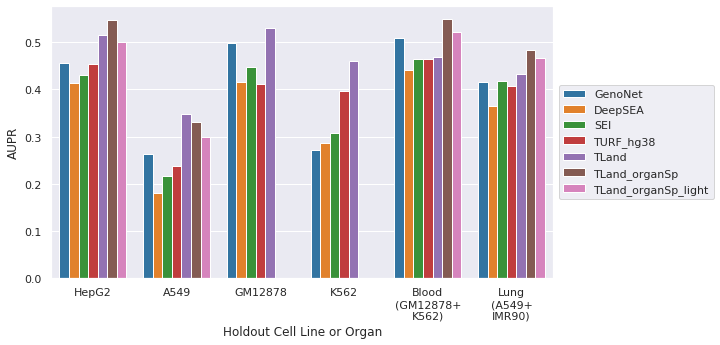

In [14]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/fig1_aupr.svg', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

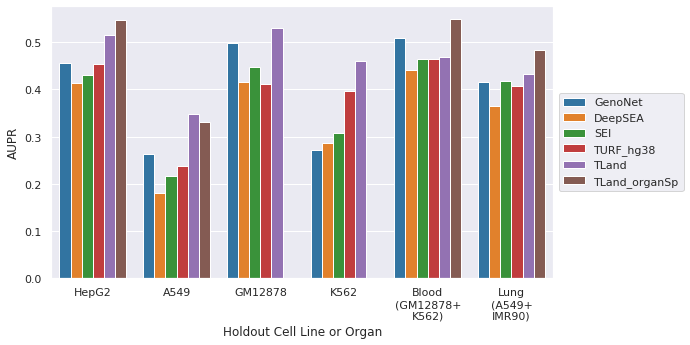

In [36]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/fig1_aupr_forDemo.png', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

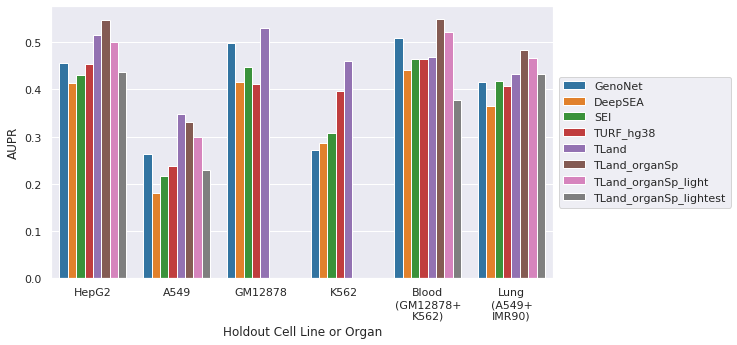

In [27]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light', 'TLand_organSp_lightest'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/fig1_aupr_forDemo.png', dpi=1000, bbox_inches='tight')

In [28]:
auroc_df = pd.DataFrame(auroc_ls, columns=['Classifier', 'Cell line', 'AUROC'])
auroc_df = auroc_df.loc[(auroc_df['Classifier'] == 'GenoNet') | 
                      (auroc_df['Classifier'] == 'DeepSEA') |
                      (auroc_df['Classifier'] == 'SEI') |
                      (auroc_df['Classifier'] == 'TURF_hg38') | 
                      (auroc_df['Classifier'] == 'TLand') | 
                      (auroc_df['Classifier'] == 'TLand_organSp') | 
                      (auroc_df['Classifier'] == 'TLand_organSp_light') | 
                      (auroc_df['Classifier'] == 'TLand_organSp_lightest'), :]

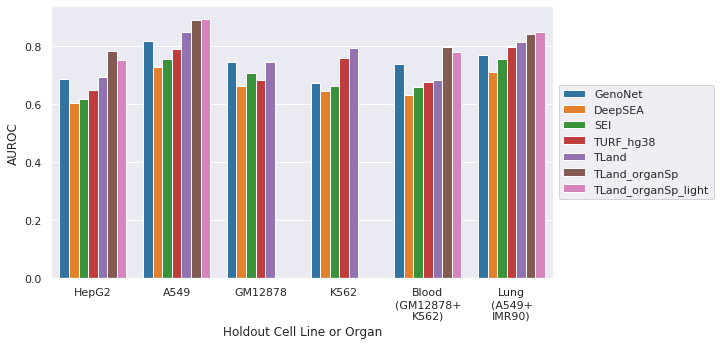

In [16]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/fig1_auroc.svg', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

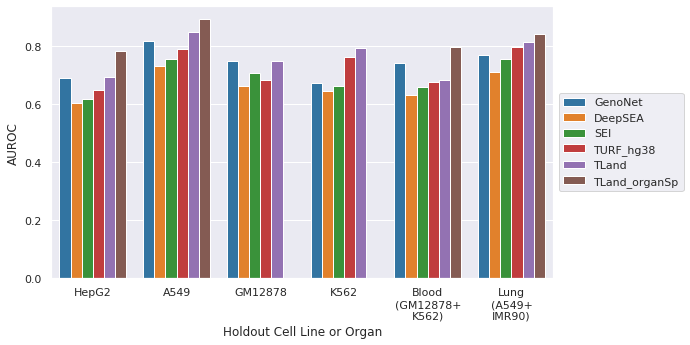

In [51]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/fig1_auroc_forDemo.png', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

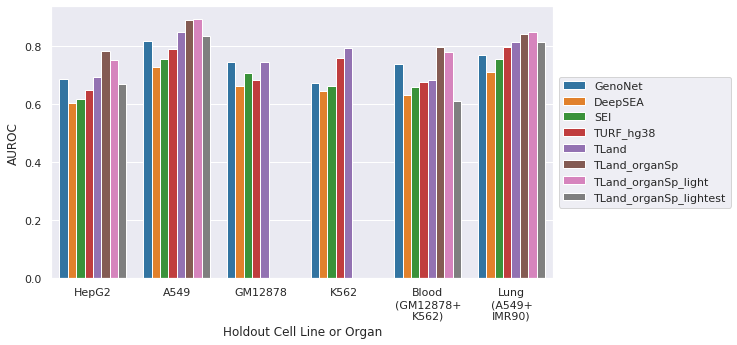

In [29]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light', 'TLand_organSp_lightest'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])
ax.set(xlabel='Holdout Cell Line or Organ')

In [64]:
cor_df = pd.DataFrame(cor_ls, columns=['Classifier', 'Cell line', 'Correlation'])
cor_df = cor_df.loc[(cor_df['Classifier'] == 'GenoNet') | 
                      (cor_df['Classifier'] == 'DeepSEA') |
                      (cor_df['Classifier'] == 'SEI') |
                      (cor_df['Classifier'] == 'TURF_hg38') | 
                      (cor_df['Classifier'] == 'TLand') | 
                      (cor_df['Classifier'] == 'TLand_organSp') |
                      (cor_df['Classifier'] == 'TLand_organSp_light'), :]

[Text(0, 0, 'HepG2'),
 Text(0, 0, 'A549'),
 Text(0, 0, 'GM12878'),
 Text(0, 0, 'K562'),
 Text(0, 0, 'Blood\n(GM12878+\nK562)'),
 Text(0, 0, 'Lung\n(A549+\nIMR90)')]

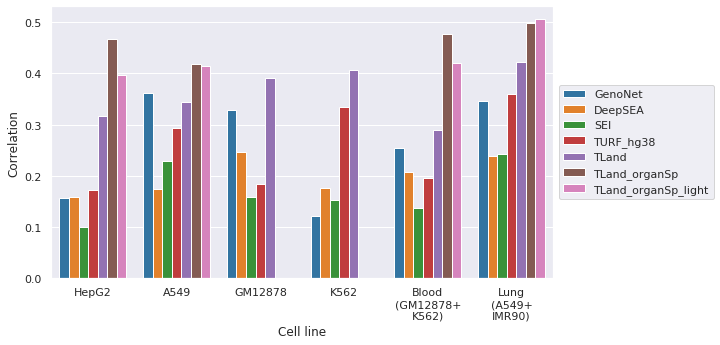

In [66]:
sns.set(rc = {'figure.figsize':(9,5)})
ax = sns.barplot(x="Cell line", y="Correlation", hue="Classifier", data=cor_df, palette='tab10', 
                 order=['HepG2', 'A549', 'GM12878', 'K562', 'Blood (GM12878 + K562)', 'Lung (A549 + IMR90)'], 
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['HepG2', 'A549', 'GM12878', 'K562', 'Blood\n(GM12878+\nK562)', 'Lung\n(A549+\nIMR90)'])

In [35]:
aupr_df = pd.DataFrame(aupr_ls, columns=['Classifier', 'Cell line', 'AUPR'])
aupr_df = aupr_df.loc[(aupr_df['Cell line'] == 'H1hESC') | 
                      (aupr_df['Cell line'] == 'MCF7') | 
                      (aupr_df['Cell line'] == 'Embryo (H1hESC + H9)') & 
                      (aupr_df['Classifier'] != 'GenoNet'), :]

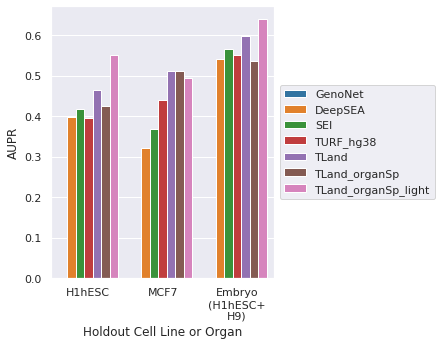

In [19]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_aupr.svg', dpi=1000, bbox_inches='tight')

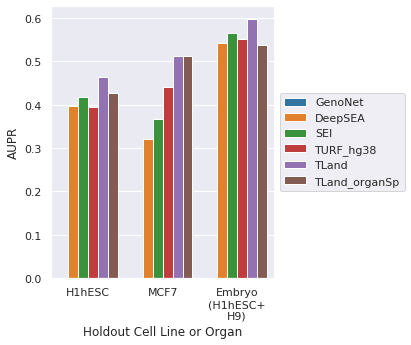

In [117]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_aupr_forDemo.png', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

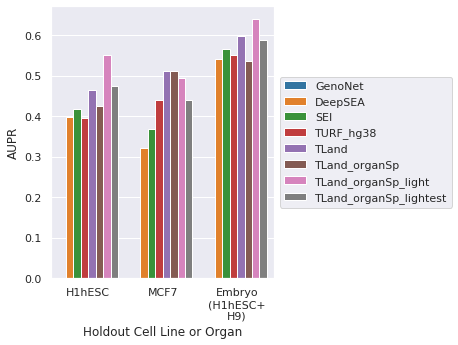

In [36]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUPR", hue="Classifier", data=aupr_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light', 'TLand_organSp_lightest'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_aupr.svg', dpi=1000, bbox_inches='tight')

In [37]:
auroc_df = pd.DataFrame(auroc_ls, columns=['Classifier', 'Cell line', 'AUROC'])
auroc_df = auroc_df.loc[(auroc_df['Cell line'] == 'H1hESC') | 
                        (auroc_df['Cell line'] == 'MCF7')| 
                      (auroc_df['Cell line'] == 'Embryo (H1hESC + H9)') & 
                      (auroc_df['Classifier'] != 'GenoNet'), :]

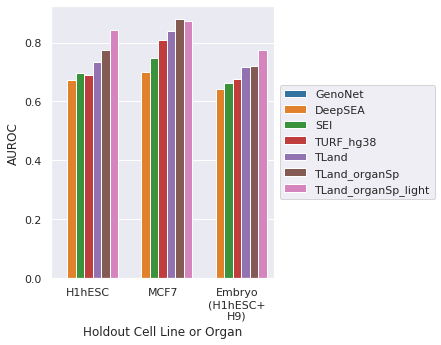

In [22]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_auroc.svg', dpi=1000, bbox_inches='tight')

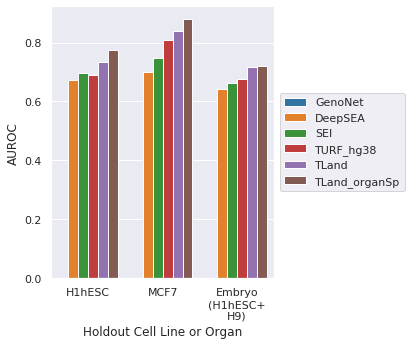

In [120]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_auroc_forDemo.svg', dpi=1000, bbox_inches='tight')

[Text(0.5, 0, 'Holdout Cell Line or Organ')]

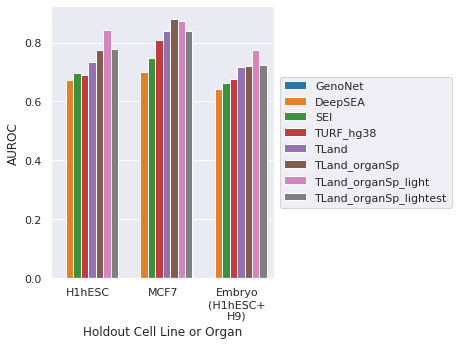

In [38]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="AUROC", hue="Classifier", data=auroc_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet', 'DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light', 'TLand_organSp_lightest'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])
ax.set(xlabel='Holdout Cell Line or Organ')
# plt.savefig('../plots/supfig_auroc.svg', dpi=1000, bbox_inches='tight')

In [73]:
cor_df = pd.DataFrame(cor_ls, columns=['Classifier', 'Cell line', 'Correlation'])
cor_df = cor_df.loc[(cor_df['Cell line'] == 'H1hESC') | 
                    (cor_df['Cell line'] == 'MCF7') |
                    (cor_df['Cell line'] == 'Embryo (H1hESC + H9)') & 
                    (cor_df['Classifier'] != 'GenoNet'), :]

[Text(0, 0, 'H1hESC'), Text(0, 0, 'MCF7'), Text(0, 0, 'Embryo\n(H1hESC+\nH9)')]

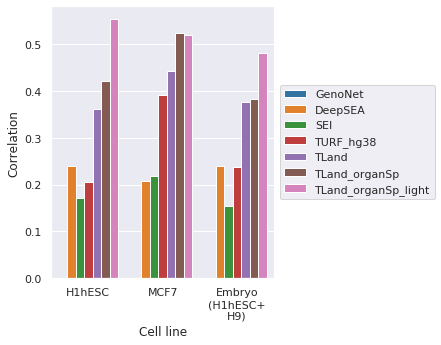

In [75]:
sns.set(rc = {'figure.figsize':(4,5)})
ax = sns.barplot(x="Cell line", y="Correlation", hue="Classifier", data=cor_df, palette='tab10',
                 order=['H1hESC', 'MCF7', 'Embryo (H1hESC + H9)'],
                 hue_order=['GenoNet','DeepSEA', 'SEI', 'TURF_hg38', 'TLand', 'TLand_organSp', 'TLand_organSp_light'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(['H1hESC', 'MCF7', 'Embryo\n(H1hESC+\nH9)'])

### 5. Full model training and output

#### 5.1 Full model training and output

In [28]:
X_train = pd.concat([df_all_dict[cell] for cell in cells], axis=0)
y_train = X_train['organSp_label']
X_train['group'] = X_train.groupby(['chrom', 'end', 'ref', 'alt']).ngroup()

In [ ]:
#TLand
class_balance = {i:class_weight for i, class_weight in zip(range(2), X_train.shape[0]/(2*np.bincount(y_train)))}
clf, name_ls = get_TLand(features_cell_sp=features_names_organ_sp_perc+features_names_organ_sp_dnase, 
                         features_sei=features_sei, 
                         features_generic=features_generic_wo_funsig, kfold=4, class_balance=class_balance, njobs=5)
clf.fit(X_train, y_train, groups=X_train['group'])
# with open('../data/models/TLand_organSp.pickle', 'wb') as file:
#     pickle.dump(clf, file)

In [ ]:
#TLand_organSp_light
clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+
                               features_names_organ_sp_perc_histone+
                               features_names_organ_sp_dnase+
                               ['CHIP_organSp_perc', 'CTCF_organSp_perc'],
                               kfold=4, class_balance=class_balance, njobs=5)
clf.fit(X_train, y_train, groups=X_train['group'])
# with open('../data/models/TLand_organSp_light.pickle', 'wb') as file:
#     pickle.dump(clf, file)

In [ ]:
#TLand_organSp_lightest
clf, name_ls = get_TLand_light(features= features_generic_wo_funsig+
                               features_names_organ_sp_perc_histone+
                               features_names_organ_sp_dnase+
                               ['CTCF_organSp_perc'],
                               kfold=4, class_balance=class_balance, njobs=5)
clf.fit(X_train, y_train, groups=X_train['group'])
# with open('../data/models/TLand_organSp_lightest.pickle', 'wb') as file:
#     pickle.dump(clf, file)

#### 5.2 Inspect models

In [5]:
with open('../data/models/TLand_organSp.pickle', 'rb') as file:
    TLand_organSp = pickle.load(file)
with open('../data/models/TLand_organSp_light.pickle', 'rb') as file:
    TLand_organSp_light = pickle.load(file)
with open('../data/models/TLand_organSp_lightest.pickle', 'rb') as file:
    TLand_organSp_lightest = pickle.load(file)

In [13]:
name_ls =  ['exp_rf', 'exp_lgbm', 'exp_nn', 
            'dl_rf','dl_lgbm','dl_nn',
            'organSp_rf', 'organSp_lgbm', 'organSp_nn']
name_ls_light = ['exp_rf', 'exp_lgbm', 'exp_nn']

In [14]:
coeff_ls = []
for clf_name, clf in [['TLand_organSp', TLand_organSp], ['TLand_organSp_light', TLand_organSp_light], ['TLand_organSp_lightest', TLand_organSp_lightest]]:
    if clf_name == 'TLand_organSp':
        for name, coeff in zip(clf.meta_clf_[0].get_feature_names_out(input_features=name_ls), clf.meta_clf_[1].coef_[0, :]):
            coeff_ls.append([name, coeff, clf_name])
    else:
        for name, coeff in zip(clf.meta_clf_[0].get_feature_names_out(input_features=name_ls_light), clf.meta_clf_[1].coef_[0, :]):
            coeff_ls.append([name, coeff, clf_name])
coeff_df = pd.DataFrame(coeff_ls, columns=['Base Classifiers and Interactions', 'Coefficient', 'Classifiers'])

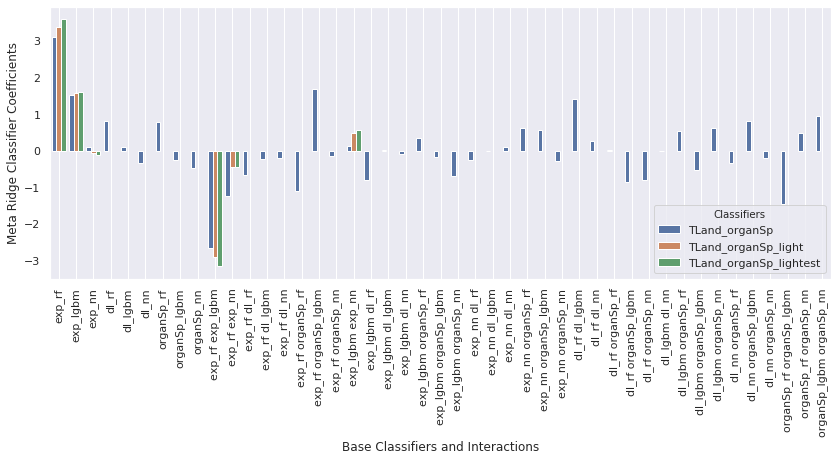

In [25]:
sns.set(rc = {'figure.figsize':(14,5)})
sns.barplot(x='Base Classifiers and Interactions', y='Coefficient', data=coeff_df, hue='Classifiers')
plt.xticks(rotation=90)
plt.ylabel('Meta Ridge Classifier Coefficients')
plt.grid()
plt.savefig('../plots/ridge_classifier_coeff.png', dpi=1300, bbox_inches='tight')